In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from Laser.abcd import Beampath
from Laser.fresnel_propag import abcd_propag, axis_vect

# Example: Propagate a beam on a beam path

## Define a beampath using the 'abcd' module

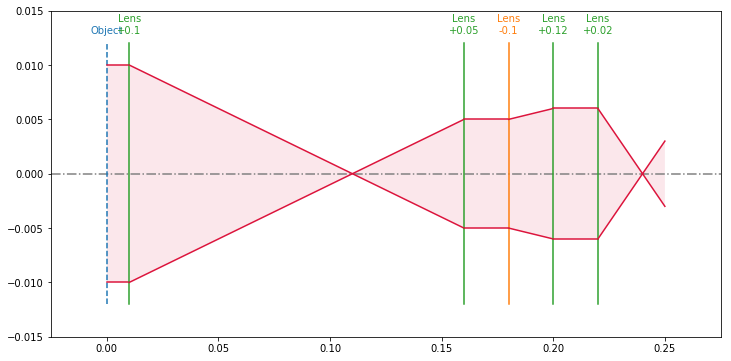

In [2]:
bp = Beampath(10e-3, 0)
bp.add_freespace(10e-3)
bp.add_thinlens(100e-3)
bp.add_freespace(150e-3)
bp.add_thinlens(50e-3)
bp.add_freespace(20e-3)
bp.add_thinlens(-100e-3)
bp.add_freespace(20e-3)
bp.add_thinlens(120e-3)
bp.add_freespace(20e-3)
bp.add_thinlens(20e-3)
bp.add_freespace(20e-3)
bp.add_freespace(10e-3)
bp.plot()

## Use Fresnel propagation along the path

In [3]:
# Simulation box size
N = 200
# Profile
profile = {'sg_order':6, 'wavelength':800e-9}
# near field and far field scaling
nf_scale = 1
ff_scale = 1

# Propagate
efield, L = abcd_propag(bp, profile, num_points=N, nf_scale=nf_scale, ff_scale=ff_scale)

# Get the absolute box size in mm
L_ = np.abs(L)*1e3

# Number of beams simulated
n = len(L)

In [4]:
# Add an aperture: center of the diverging lens is blocked

# Initialise mask
mask = np.ones([n, N, N])
mask_pos = 6 # Divergent lens is in the 7th position
# Get transverse axis
x = axis_vect(N)/N*L[mask_pos]
X,Y = np.meshgrid(x,x)

# Cut half the radius
aperture = np.sqrt(X**2+Y**2)>= np.abs(bp.radius[mask_pos])/2
mask[mask_pos,:,:] = 1.*aperture # set the aperture as float and add it to the masks

# Re-propagate with the aperture
efield, L = abcd_propag(bp, profile, num_points=N, aperture=mask, nf_scale=nf_scale, ff_scale=ff_scale)

## Display results

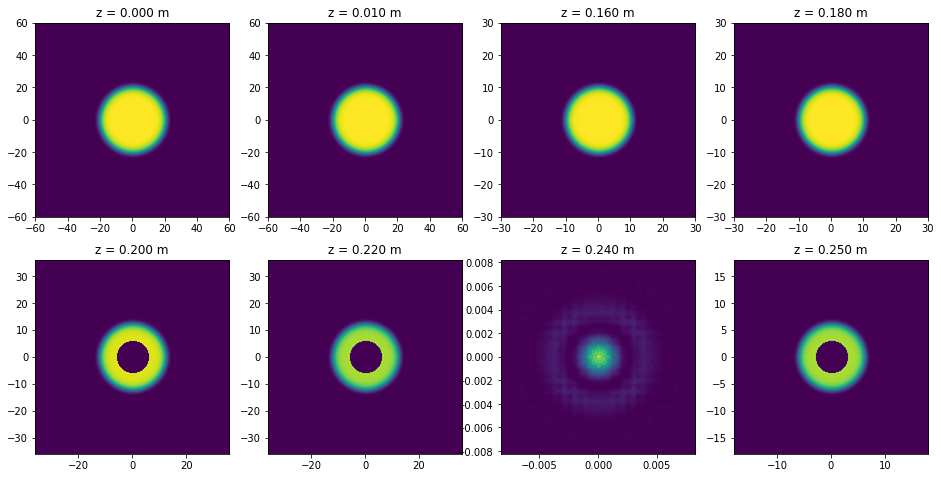

In [6]:
# Only show the beam after free space propagation
from Laser.abcd import Freespace, Object

n_plot = len([elem for elem in bp.list_elements if isinstance(elem, Freespace) or isinstance(elem, Object)])

# Initialise subplots
n_sub_hor = 4
fig, ax = plt.subplots(int(np.ceil(n_plot/n_sub_hor)),n_sub_hor, figsize=(16,8))

# Counter for subplots
idx_plot = 0

for i in range(n):
    if isinstance(bp.list_elements[i], Freespace) or isinstance(bp.list_elements[i], Object):
        ax[int(np.floor(idx_plot/n_sub_hor)),
           int(idx_plot-n_sub_hor*np.floor(idx_plot/n_sub_hor))].imshow(np.abs(efield[i, :, :])**2, extent=[-L_[i],L_[i],-L_[i],L_[i]])
        ax[int(np.floor(idx_plot/n_sub_hor)),
           int(idx_plot-n_sub_hor*np.floor(idx_plot/n_sub_hor))].set_title('z = %.3f m' % bp.position[i])
        idx_plot += 1


The far field is distorded because of the box size...
Let's repropagate but increasing the far field box scale!

Nevertheless, we see the diffraction from the hole kicking in after some propagation and increase the intensity around the edge

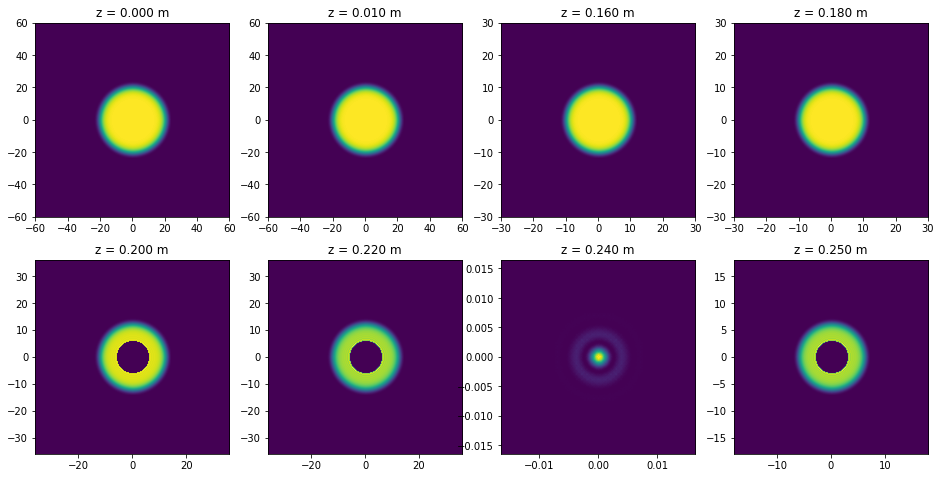

In [7]:
# Re-propagate with the aperture, and increase the far field scale to avoid reflection at the box edges
efield2, L2 = abcd_propag(bp, profile, num_points=N, aperture=mask, nf_scale=nf_scale, ff_scale=2*ff_scale)

L2_ = np.abs(L2)*1e3

# Set subplots
fig, ax = plt.subplots(int(np.ceil(n_plot/n_sub_hor)),n_sub_hor, figsize=(16,8))

# Counter for subplots
idx_plot = 0

for i in range(n):
    if isinstance(bp.list_elements[i], Freespace) or isinstance(bp.list_elements[i], Object):
        ax[int(np.floor(idx_plot/n_sub_hor)),
           int(idx_plot-n_sub_hor*np.floor(idx_plot/n_sub_hor))].imshow(np.abs(efield2[i, :, :])**2, extent=[-L2_[i],L2_[i],-L2_[i],L2_[i]])
        ax[int(np.floor(idx_plot/n_sub_hor)),
           int(idx_plot-n_sub_hor*np.floor(idx_plot/n_sub_hor))].set_title('z = %.3f m' % bp.position[i])
        idx_plot += 1

Much better! Let's zoom in on the far field

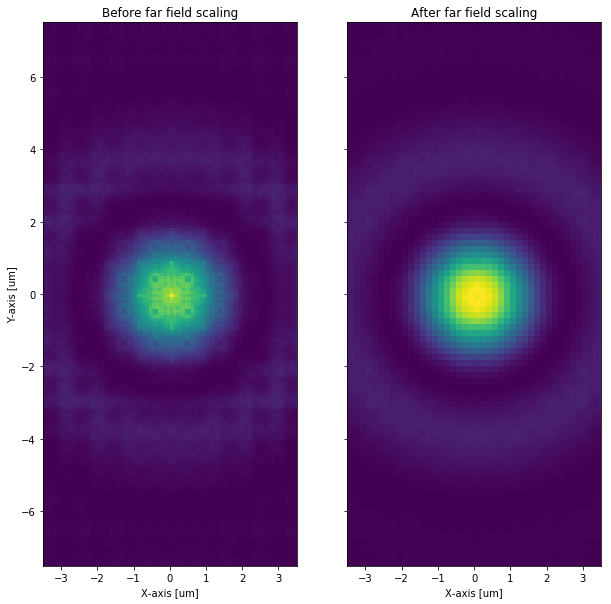

In [8]:
x1 = L_[-2]*1e3
x2 = L2_[-2]*1e3

fig2, ax2 = plt.subplots(1,2,figsize=(10,10), sharey=True)
ax2[0].imshow(np.abs(efield[-2,:,:])**2, extent = [-x1, x1, -x1, x1])
ax2[0].set_xlim(-7.5, 7.5)
ax2[0].set_ylim(-7.5, 7.5)
ax2[0].set_title('Before far field scaling')
ax2[0].set_xlabel('X-axis [um]')
ax2[0].set_ylabel('Y-axis [um]')

ax2[1].imshow(np.abs(efield2[-2,:,:])**2, extent = [-x2, x2, -x2, x2])
ax2[1].set_xlim(-7.5, 7.5)
ax2[1].set_ylim(-7.5, 7.5)
ax2[1].set_title('After far field scaling')
ax2[1].set_xlabel('X-axis [um]');

We loose resolution but gain accuracy.

However, please mind that the near field and far field scaling does not scale the aperture!!